## Speech recognition

__You should be able to do this exercise after Lecture 9.__

In this exercise, we will work with the <a href="https://arxiv.org/pdf/1804.03209.pdf">Google Speech Command Dataset</a>, which can be downloaded from <a href="http://download.tensorflow.org/data/speech_commands_v0.02.tar.gz">here</a> (note: you do not need to download the full dataset, but it will allow you to play around with the raw audiofiles). This dataset contains 105,829 one-second long audio files with utterances of 35 common words.

We will use a subset of this dataset as indicated in the table below.

| Word | How many? | Class # |
| :-: | :-: | :-: |
| Yes | 4,044 | 3 |
| No | 3,941 | 1 |
| Stop | 3,872 | 2 |
| Go | 3,880 | 0 |

The data is given in the files `XSound.npy` and `YSound.npy`, both of which can be imported using `numpy.load`. `XSound.npy` contains spectrograms (_e.g._, matrices with a time-axis and a frequency-axis of size 62 (time) x 65 (frequency)). `YSound.npy` contains the class number, as indicated in the table above.

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras import layers, models

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

from scikeras.wrappers import KerasClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import classification_report




AttributeError: module 'inspect' has no attribute 'ArgSpec'

In [ ]:
XSound = np.load("XSound.npy")
YSound = np.load("YSound.npy")

word_class = {3: "Yes", 2: "Stop", 1: "No", 0: "Go"}

In [ ]:
print(XSound.shape)
print(YSound.shape)

(15737, 62, 65, 1)
(15737,)


In [ ]:
word_class[YSound[1200]]

'No'

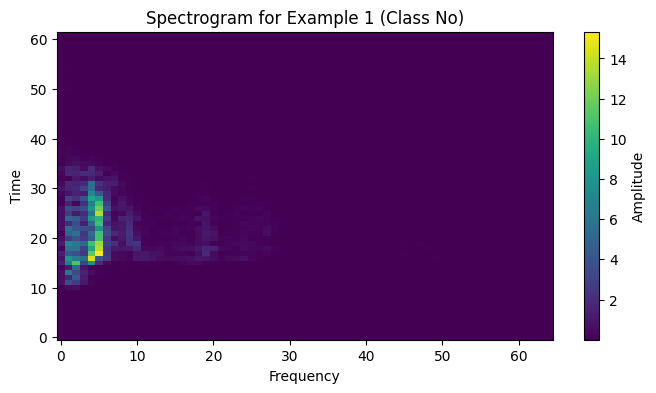

In [ ]:
# Extract the spectrogram and class label for the chosen example
spectrogram = XSound[1, :, :, 0]
class_label = YSound[1]

# Visualize the spectrogram
plt.figure(figsize=(8, 4))
plt.imshow(spectrogram, aspect="auto", cmap="viridis", origin="lower")
plt.title(f"Spectrogram for Example {1} (Class {word_class.get(class_label)})")
plt.xlabel("Frequency")
plt.ylabel("Time")
plt.colorbar(label="Amplitude")
plt.show()

In [ ]:
XSound_normalized = XSound / np.max(np.abs(XSound)) #Changes the data to -1 to 1
XSound_log_normalized = np.log1p(XSound_normalized)
XSound_log = np.log1p(XSound)

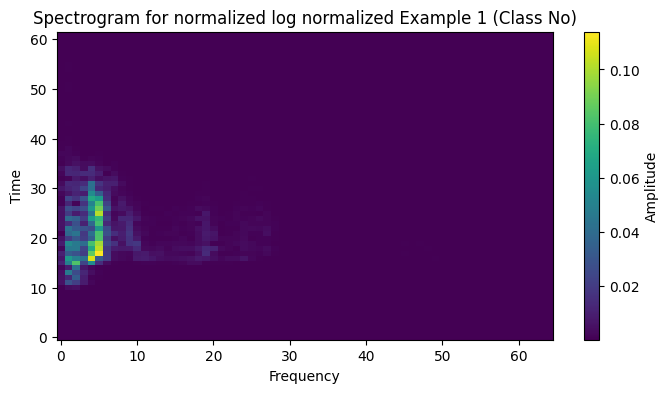

In [ ]:
# Extract the spectrogram and class label for the chosen example
spectrogram = XSound_log_normalized[1, :, :, 0]
class_label = YSound[1]

# Visualize the spectrogram
plt.figure(figsize=(8,4))
plt.imshow(spectrogram, aspect="auto", cmap="viridis", origin="lower")
plt.title(f"Spectrogram for normalized log normalized Example {1} (Class {word_class.get(class_label)})")
plt.xlabel("Frequency")
plt.ylabel("Time")
plt.colorbar(label="Amplitude")
plt.show()

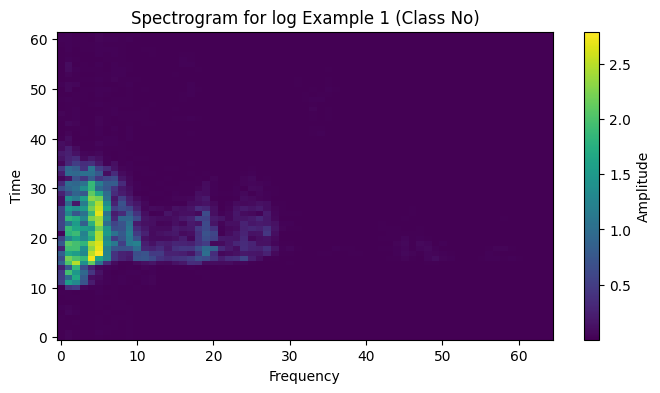

In [ ]:
# Extract the spectrogram and class label for the chosen example
spectrogram = XSound_log[1, :, :, 0]
class_label = YSound[1]

# Visualize the spectrogram
plt.figure(figsize=(8,4))
plt.imshow(spectrogram, aspect="auto", cmap="viridis", origin="lower")
plt.title(f"Spectrogram for log Example {1} (Class {word_class.get(class_label)})")
plt.xlabel("Frequency")
plt.ylabel("Time")
plt.colorbar(label="Amplitude")
plt.show()

In [ ]:
# Function to create the model
num_classes = len(word_class)

def create_model(learning_rate=0.001, num_filters=32, filter_size=(3, 3), pool_size=(2, 2), dense_units=128, dropout_rate=0.25, optimizer="adam"):
    model = models.Sequential()
    
    model.add(layers.Conv2D(num_filters, filter_size, activation='relu', input_shape=(62, 65, 1)))
    model.add(layers.MaxPooling2D(pool_size))
    
    model.add(layers.Conv2D(2*num_filters, filter_size, activation='relu'))
    model.add(layers.MaxPooling2D(pool_size))
    
    model.add(layers.Conv2D(4*num_filters, filter_size, activation='relu'))
    model.add(layers.MaxPooling2D(pool_size))
    
    model.add(layers.Flatten())
    model.add(layres.Dense(dense_units, activation='relu'))
    model.add(layers.Dropout(dropout_rate))
    model.add(layers.Dense(num_classes, activation='softmax'))
    if optimizer == "adam":
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    elif optimizer == "sgd":
        optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)
    else:
        print("invalid optimizer")
        exit()

    model.compile(optimizer=optimizer,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

In [ ]:
def plot_lines(history): 
    fig, axs = plt.subplots(1, 2, figsize=(15, 4))
    
    axs[0].plot(history.history['accuracy'], label='Train Accuracy')
    axs[0].plot(history.history['val_accuracy'], label='Validation Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('Accuracy')
    axs[0].legend()
    
    axs[1].plot(history.history['loss'], label='Train Loss')
    axs[1].plot(history.history['val_loss'], label='Validation Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Loss')
    axs[1].legend()

    plt.show()

## Using raw data

In [ ]:
# Assuming XSound and YSound are your spectrogram and label data
# Split the data into training and test sets
X_train, X_test, Y_train, Y_test = train_test_split(XSound, YSound, test_size=0.2, random_state=42)

# Further split the training data into training and validation sets
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.1, random_state=42)

# Print the shapes of the resulting sets
print("X_train shape:", X_train.shape)
print("Y_train shape:", Y_train.shape)
print("X_val shape:", X_val.shape)
print("Y_val shape:", Y_val.shape)
print("X_test shape:", X_test.shape)
print("Y_test shape:", Y_test.shape)


X_train shape: (11330, 62, 65, 1)
Y_train shape: (11330,)
X_val shape: (1259, 62, 65, 1)
Y_val shape: (1259,)
X_test shape: (3148, 62, 65, 1)
Y_test shape: (3148,)


In [ ]:
model = create_model()

2023-11-18 13:47:26.245238: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-18 13:47:26.278211: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-18 13:47:26.278428: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [ ]:
# Assuming you have defined and compiled your model as 'model'
history = model.fit(X_train, Y_train, epochs=5, batch_size=16, validation_data=(X_val, Y_val))

Epoch 1/5


2023-11-18 13:47:28.366963: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8905
2023-11-18 13:47:28.826042: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x56108ff457c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-11-18 13:47:28.826099: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1650, Compute Capability 7.5
2023-11-18 13:47:28.840779: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-11-18 13:47:29.014186: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


709/709 [==============================] - 9s 7ms/step - loss: 0.5409 - accuracy: 0.7984 - val_loss: 0.2700 - val_accuracy: 0.9087
Epoch 2/5
709/709 [==============================] - 5s 6ms/step - loss: 0.2428 - accuracy: 0.9175 - val_loss: 0.1962 - val_accuracy: 0.9333
Epoch 3/5
709/709 [==============================] - 4s 6ms/step - loss: 0.1494 - accuracy: 0.9479 - val_loss: 0.1855 - val_accuracy: 0.9341
Epoch 4/5
709/709 [==============================] - 4s 6ms/step - loss: 0.1183 - accuracy: 0.9586 - val_loss: 0.1348 - val_accuracy: 0.9484
Epoch 5/5
709/709 [==============================] - 4s 6ms/step - loss: 0.0974 - accuracy: 0.9650 - val_loss: 0.1554 - val_accuracy: 0.9476


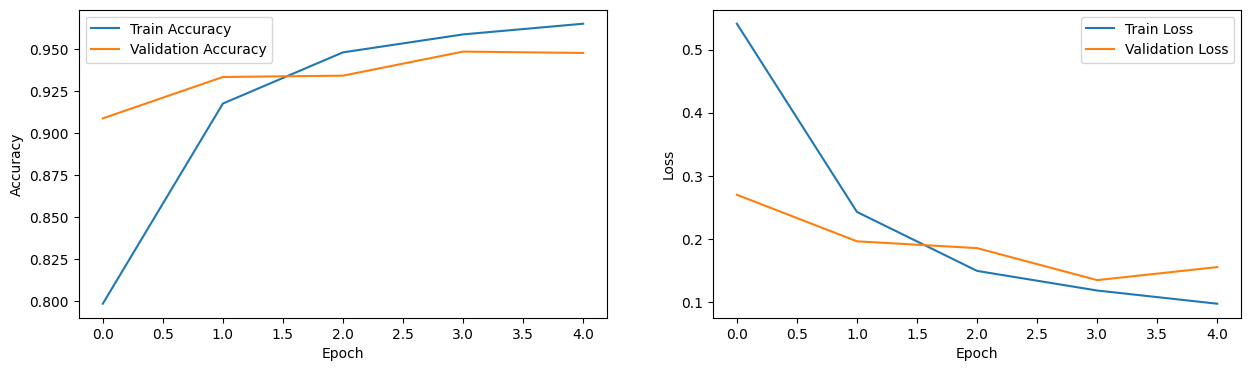

In [ ]:
plot_lines(history)

In [ ]:
test_loss, test_acc = model.evaluate(X_test, Y_test)
print("Test accuracy:", test_acc)

99/99 [==============================] - 1s 5ms/step - loss: 0.1204 - accuracy: 0.9558
Test accuracy: 0.9558449983596802


## log normalized data

In [ ]:
X_train_ln, X_test_ln, Y_train_ln, Y_test_ln = train_test_split(XSound_log_normalized, YSound, test_size=0.2, random_state=42)
X_train_ln, X_val_ln, Y_train_ln, Y_val_ln = train_test_split(X_train_ln, Y_train_ln, test_size=0.1, random_state=42)

print("X_train shape:", X_train_ln.shape)
print("Y_train shape:", Y_train_ln.shape)
print("X_val shape:", X_val_ln.shape)
print("Y_val shape:", Y_val_ln.shape)
print("X_test shape:", X_test_ln.shape)
print("Y_test shape:", Y_test_ln.shape)

X_train shape: (11330, 62, 65, 1)
Y_train shape: (11330,)
X_val shape: (1259, 62, 65, 1)
Y_val shape: (1259,)
X_test shape: (3148, 62, 65, 1)
Y_test shape: (3148,)


In [ ]:
model_ln = create_model()

In [ ]:
history_ln = model_ln.fit(X_train_ln, Y_train_ln, epochs=5, batch_size=16, validation_data=(X_val_ln, Y_val_ln))

Epoch 1/5
709/709 [==============================] - 7s 6ms/step - loss: 0.7756 - accuracy: 0.6682 - val_loss: 0.5705 - val_accuracy: 0.7657
Epoch 2/5
709/709 [==============================] - 4s 6ms/step - loss: 0.4444 - accuracy: 0.8320 - val_loss: 0.3749 - val_accuracy: 0.8435
Epoch 3/5
709/709 [==============================] - 4s 6ms/step - loss: 0.3204 - accuracy: 0.8796 - val_loss: 0.2758 - val_accuracy: 0.8928
Epoch 4/5
709/709 [==============================] - 4s 6ms/step - loss: 0.2459 - accuracy: 0.9119 - val_loss: 0.3121 - val_accuracy: 0.8856
Epoch 5/5
709/709 [==============================] - 4s 6ms/step - loss: 0.2070 - accuracy: 0.9234 - val_loss: 0.2178 - val_accuracy: 0.9134


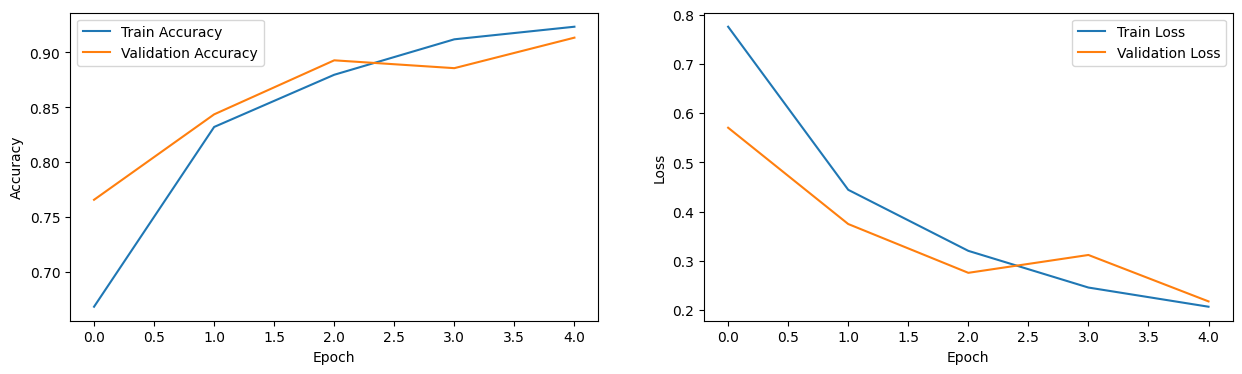

In [ ]:
plot_lines(history_ln)

In [ ]:
test_loss_ln, test_acc_ln = model_ln.evaluate(X_test_ln, Y_test_ln)
print("Test accuracy:", test_acc_ln)

99/99 [==============================] - 0s 4ms/step - loss: 0.2137 - accuracy: 0.9190
Test accuracy: 0.9189962148666382


## Hyperparameter optimization

In [ ]:
model = KerasClassifier(model=create_model, batch_size=16, verbose=0)

In [ ]:
param_grid = {
    'optimizer': ['adam', 'sgd'],  # Add other optimizers as needed
    'batch_size': [8,16,32],
    'epochs': [2,4,6]
}

In [ ]:
# Use StratifiedKFold for cross-validation since it's a classification problem
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# Perform grid search
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=cv, scoring='accuracy', verbose=10)
grid_result = grid.fit(X_train_ln, Y_train_ln)

Fitting 3 folds for each of 18 candidates, totalling 54 fits
[CV 1/3; 1/18] START batch_size=8, epochs=2, optimizer=adam.....................
[CV 1/3; 1/18] END batch_size=8, epochs=2, optimizer=adam;, score=0.849 total time=  12.6s
[CV 2/3; 1/18] START batch_size=8, epochs=2, optimizer=adam.....................
[CV 2/3; 1/18] END batch_size=8, epochs=2, optimizer=adam;, score=0.849 total time=  11.9s
[CV 3/3; 1/18] START batch_size=8, epochs=2, optimizer=adam.....................
[CV 3/3; 1/18] END batch_size=8, epochs=2, optimizer=adam;, score=0.862 total time=  12.1s
[CV 1/3; 2/18] START batch_size=8, epochs=2, optimizer=sgd......................
[CV 1/3; 2/18] END batch_size=8, epochs=2, optimizer=sgd;, score=0.854 total time=  12.0s
[CV 2/3; 2/18] START batch_size=8, epochs=2, optimizer=sgd......................
[CV 2/3; 2/18] END batch_size=8, epochs=2, optimizer=sgd;, score=0.847 total time=  12.0s
[CV 3/3; 2/18] START batch_size=8, epochs=2, optimizer=sgd......................


In [ ]:
# Print the best parameters and the corresponding accuracy
print("Best parameters found: ", grid_result.best_params_)
print("Best accuracy found: ", grid_result.best_score_)

Best parameters found:  {'batch_size': 8, 'epochs': 6, 'optimizer': 'adam'}
Best accuracy found:  0.9156223028469969


In [ ]:
# Extract the best hyperparameters from the grid search results
best_params = grid_result.best_params_

# Create the model with the best hyperparameters
best_model = create_model(optimizer=best_params['optimizer'])

# Train the model with the training data
history_best = best_model.fit(X_train_ln, Y_train_ln, epochs=best_params['epochs'], batch_size=best_params['batch_size'], validation_data=(X_val, Y_val))


Epoch 1/6
1417/1417 [==============================] - 10s 6ms/step - loss: 0.7336 - accuracy: 0.6900 - val_loss: 19.5860 - val_accuracy: 0.8006
Epoch 2/6
1417/1417 [==============================] - 8s 6ms/step - loss: 0.3833 - accuracy: 0.8543 - val_loss: 20.6564 - val_accuracy: 0.8197
Epoch 3/6
1417/1417 [==============================] - 8s 6ms/step - loss: 0.2850 - accuracy: 0.8961 - val_loss: 11.1681 - val_accuracy: 0.8602
Epoch 4/6
1417/1417 [==============================] - 10s 7ms/step - loss: 0.2189 - accuracy: 0.9214 - val_loss: 8.7290 - val_accuracy: 0.8824
Epoch 5/6
1417/1417 [==============================] - 9s 6ms/step - loss: 0.1808 - accuracy: 0.9307 - val_loss: 13.8563 - val_accuracy: 0.8777
Epoch 6/6
1417/1417 [==============================] - 11s 8ms/step - loss: 0.1612 - accuracy: 0.9416 - val_loss: 16.5171 - val_accuracy: 0.8594


In [ ]:
# Assuming 'best_model' is the model trained with the best hyperparameters
predictions = best_model.predict(X_test_ln)

# The predictions are in the form of class probabilities, so you might want to convert them to class labels
predicted_labels = np.argmax(predictions, axis=1)

99/99 [==============================] - 0s 3ms/step


In [ ]:
cm = confusion_matrix(Y_test_ln, predicted_labels)
accuracy = accuracy_score(Y_test_ln, predicted_labels)
f1 = f1_score(Y_test_ln, predicted_labels, average="weighted")
clf_report = classification_report(Y_test_ln, predicted_labels)
print("Test accuracy : ", accuracy)
print("f1 score : ", f1)
print("Classification report : ", clf_report)

Test accuracy :  0.9113722998729352
f1 score :  0.9119440994663887
Classification report :                precision    recall  f1-score   support

           0       0.80      0.95      0.87       810
           1       0.92      0.80      0.86       781
           2       0.97      0.95      0.96       752
           3       0.99      0.95      0.97       805

    accuracy                           0.91      3148
   macro avg       0.92      0.91      0.91      3148
weighted avg       0.92      0.91      0.91      3148



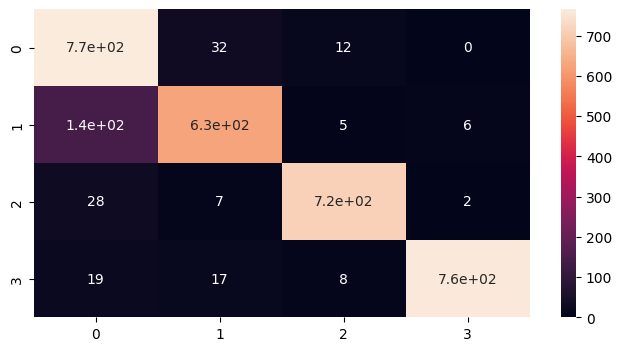

In [ ]:
plt.figure(figsize=(8,4))
sns.heatmap(cm, annot=True)
plt.show()

## Using a RF classifier as well

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
# Create a Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Flatten the spectrogram data for Random Forest (assuming each row is treated as a separate sample)
X_train_flat = X_train.reshape(X_train_ln.shape[0], -1)
X_test_flat = X_test.reshape(X_test_ln.shape[0], -1)

# Train the classifier
rf_classifier.fit(X_train_flat, Y_train)

RandomForestClassifier(random_state=42)

In [ ]:
# Make predictions on the test set
rf_predictions = rf_classifier.predict(X_test_flat)

In [ ]:
rf_cm = confusion_matrix(Y_test_ln, rf_predictions)
rf_accuracy = accuracy_score(Y_test_ln, rf_predictions)
rf_f1 = f1_score(Y_test_ln, rf_predictions, average="weighted")
rf_clf_report = classification_report(Y_test_ln, rf_predictions)

print("Test accuracy : ", rf_accuracy)
print("f1 score : ", rf_f1)
print("Classification report : ", rf_clf_report)

Test accuracy :  0.8405336721728082
f1 score :  0.8413095779544033
Classification report :                precision    recall  f1-score   support

           0       0.74      0.76      0.75       810
           1       0.76      0.76      0.76       781
           2       0.93      0.92      0.93       752
           3       0.94      0.92      0.93       805

    accuracy                           0.84      3148
   macro avg       0.84      0.84      0.84      3148
weighted avg       0.84      0.84      0.84      3148



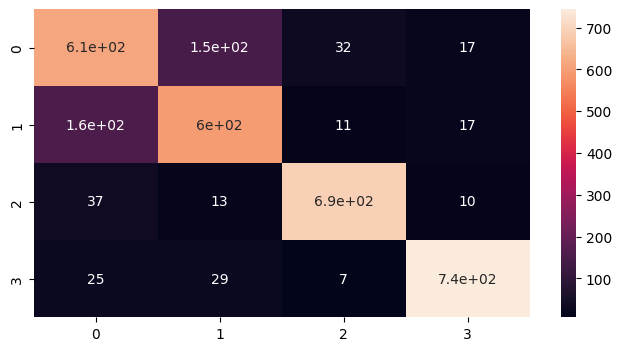

In [ ]:
plt.figure(figsize=(8,4))
sns.heatmap(rf_cm, annot=True)
plt.show()

__(a)__ Train a convolutional neural network on the data. Find a good set of hyperparameters for the model. Do you think a convolutional neural network is suitable for this kind of problem? Why/why not?

__(b)__ Classify instances of the test set using your models. Draw a confusion matrix and comment on the results.

__(c)__ Choose one other algorithm from the course, and redo (a) and (b) using this algorithm. Supply a brief discussion of why we would expect this algorithm to do better/worse than the CNN.